Evaluation and Checks
===============

# Import and Set Up

In [1]:
from src.settings import Settings
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from src.utils.data import *
import uuid
import glob

In [2]:
# Settings
settings = Settings(_env_file="paths/.env.dev") 
plt.style.use('fivethirtyeight')
enriched_dataset = pd.read_csv(settings.BASELINE_MDK_ENRICHED_DATA)
enriched_dataset["uuid"] = [uuid.uuid4() for i in range(0, len(enriched_dataset))]

In [3]:
from src.utils.data import load_json
taxonomy = load_json(settings.TAXONOMY_PROCESSED_V3)

In [5]:
data_raw = pd.read_csv("extraction/musterdatenkatalog/2023-04-20_musterdatenkatalog.csv")
data_raw["uuid"] = [uuid.uuid4() for i in range(0, len(data_raw))]
data = data_raw.copy()

# # remove duplicates 
# dct_identifier_duplicates = ['5dfdbf5b-ab87-4f10-9560-b0eda338a05a',
#        '85e8c7ac-5051-46ce-b92e-b83b5c2a1633',
#        'a1f36ee1-b81d-4181-8acc-ef7c1860b773',
#        'b824986d-57b2-43f1-9cf5-ec62e01d3470',]

# data_without_duplicates = data_raw[~data_raw["dct:identifier"].isin(dct_identifier_duplicates)]
# data_with_duplicates = data_raw[data_raw["dct:identifier"].isin(dct_identifier_duplicates)]

# data_with_duplicates_cleaned = data_with_duplicates.drop_duplicates(subset="dct:identifier")

# data = pd.concat([data_without_duplicates, data_with_duplicates_cleaned])

#  Check against current dataset list

In [6]:
from src.components.scraper import Scraper

scraper = Scraper()
scraper.get_current_dataset_list()
len(scraper.current_dataset_list)

file_paths = glob.glob("extraction/gov_data_responses/*.xml")

def check_if_all_files_are_downloaded(current_dataset_list, file_paths):
    file_paths_datasets = [el.split("/")[-1].split(".")[0] for el in file_paths]
    if set(current_dataset_list) == set(file_paths_datasets):
        print("equal")
    if len(set(file_paths_datasets).difference(set(current_dataset_list))) > 0:
        print("file paths have paths that are not in current dataset list")
    if len(set(current_dataset_list).difference(set(file_paths_datasets))) > 0:
        print("current dataset list has paths that are not in file paths")
        differences = set(current_dataset_list).difference(set(file_paths_datasets))
        return differences
    
differences = check_if_all_files_are_downloaded(scraper.current_dataset_list, file_paths)

2023-04-20 09:53:04,017 [INFO] HTTP Request: GET https://ckan.govdata.de/api/3/action/package_list "HTTP/1.1 200 OK"


file paths have paths that are not in current dataset list


In [38]:
len(scraper.current_dataset_list)

79021

## Check against missing data from old enriched file

In [7]:
import pandas as pd

# Create example dataframes
enriched_dataset_old = enriched_dataset[["dct:identifier", "dct:title", "ORG"]]
data_raw_new = data_raw[["dct:identifier", "dct:title", "ORG"]]

# Merge dataframes and add indicator column
df_merged = enriched_dataset_old.merge(data_raw_new, on=["dct:title"], how='outer', indicator=True)
df_merged_left_only = df_merged[df_merged["_merge"] == "left_only"]

In [8]:
df_merged_left_only_titles = df_merged_left_only["dct:title"].tolist()

import re
df_merged_left_only_titles_cleaned = []

for el in df_merged_left_only_titles:
    el_removed = el.lower().replace(" ", "-").replace("/", "-")
    el_removed = el_removed.replace("ä", "a")
    el_removed = el_removed.replace("ü", "u")
    el_removed = el_removed.replace("ö", "o")
    df_merged_left_only_titles_cleaned.append(re.sub(r"\-+", "-", el_removed))

print(f"{len(set(df_merged_left_only_titles_cleaned))} titels in the old dataset that are not in the new dataset")
missing_data_in_new_data  = set(df_merged_left_only_titles_cleaned).intersection(set(scraper.current_dataset_list))
print(f"{len(missing_data_in_new_data)} titels in the old dataset that are not in the new dataset but are in the current dataset list")

# check paths 
## check against all data
all_data_from_pipeline = pd.read_csv("all_data_check.csv")
all_data_from_pipeline_file_paths = all_data_from_pipeline["file_path"].tolist()
all_data_from_pipeline_file_paths_cleaned = [el.split("/")[-1].split(".")[0] for el in all_data_from_pipeline_file_paths]
print(f"{len(set(all_data_from_pipeline_file_paths_cleaned).intersection(set(missing_data_in_new_data)))} titles could be found in the all data from pipeline")

672 titels in the old dataset that are not in the new dataset
64 titels in the old dataset that are not in the new dataset but are in the current dataset list
64 titles could be found in the all data from pipeline


/var/folders/xl/z1tpcvt543qcwq5gmzjzhcjc0000gn/T/ipykernel_26949/1182847521.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_from_pipeline = pd.read_csv("all_data_check.csv")


In [13]:
filtered_data_from_pipeline = pd.read_csv("extraction/musterdatenkatalog/musterdatenkatalog.csv")
filtered_data_from_pipeline_paths = filtered_data_from_pipeline["file_path"].to_list()
filtered_data_from_pipeline_paths_cleaned = [el.split("/")[-1].split(".")[0] for el in filtered_data_from_pipeline_paths]
print(f"{len(set(filtered_data_from_pipeline_paths_cleaned).intersection(set(missing_data_in_new_data)))} titles could be found in the filtered data from pipeline")
actual_missing_data_in_new_data = set(missing_data_in_new_data).difference(set(filtered_data_from_pipeline_paths_cleaned))
actual_missing_data_in_new_data_paths = [f"extraction/gov_data_responses/{el}.xml" for el in actual_missing_data_in_new_data]

# # get updated date and check if city is nan 
print(all_data_from_pipeline[all_data_from_pipeline["file_path"].isin(actual_missing_data_in_new_data_paths)][["updated_at", "city"]]["city"].isna().sum())
print(all_data_from_pipeline[all_data_from_pipeline["file_path"].isin(actual_missing_data_in_new_data_paths)][["updated_at", "city"]]["updated_at"].min())
all_data_from_pipeline[all_data_from_pipeline["file_path"].isin(actual_missing_data_in_new_data_paths)].sort_values(by="updated_at")

16 titles could be found in the filtered data from pipeline
48
2019-09-17


,dct:title,dct:identifier,url,dct:description,distribution_description,city,license,categories,tags,updated_at,added,file_path
77715,Europawahlen,24f98ae1-31b1-5446-9801-4e9c5b0adc2e,https://opendata.leipzig.de/dataset/24f98ae1-3...,Hinweise zu den Daten: Ergebnisse der Europawa...,"Wahlen / Europawahlen, Wahlen / Europawahlen",NaN,http://dcat-ap.de/def/licenses/dl-by-de/2.0,NaN,wahlen,2019-09-17,2023-04-20,extraction/gov_data_responses/europawahlen.xml
10071,Statistisches Jahrbuch,StaNord_CMS:62184,https://opendata.schleswig-holstein.de/dataset...,Statistisches Jahrbuch - Schleswig-Holstein 20...,NaN,NaN,http://dcat-ap.de/def/licenses/dl-by-de/2.0,NaN,"jahrbücher, schleswig-holstein",2020-07-08,2023-04-20,extraction/gov_data_responses/statistisches-ja...
1591,Bodenrichtwerte 1996-2001,3a6e3b63-5f7f-4b62-a725-0ff8c80be599,https://open-data.bielefeld.de/dataset/bodenri...,<![CDATA[Die Bodenrichtwerte werden vom Gutach...,NaN,NaN,http://dcat-ap.de/def/licenses/other-closed,NaN,"bauen-und-wohnen, geo, infrastruktur",2021-07-20,2023-04-20,extraction/gov_data_responses/bodenrichtwerte-...
49564,Bodenrichtwerte 2002-2011,e5a5e1ab-ff33-4e00-a3ea-93869709c1d4,https://open-data.bielefeld.de/dataset/bodenri...,<![CDATA[\n\n\nDie Bodenrichtwerte werden vom ...,<![CDATA[\n\n\nHier finden Sie eine onlineKART...,NaN,http://dcat-ap.de/def/licenses/other-closed,NaN,"bauen-und-wohnen, geo, infrastruktur",2021-07-20,2023-04-20,extraction/gov_data_responses/bodenrichtwerte-...
49493,Kindertageseinrichtungen Wuppertal,84c2a83b-a954-4faf-b7bf-0ecd76da4f1c,https://www.offenedaten-wuppertal.de/dataset/k...,"<![CDATA[Der Datensatz ""Kindertageseinrichtung...",<![CDATA[Inhalt: interaktive Karte zu den Kind...,NaN,http://dcat-ap.de/def/licenses/cc-by/4.0,NaN,"bauen-und-wohnen, betreuungsangebot, bildung-u...",2021-09-28,2023-04-20,extraction/gov_data_responses/kindertageseinri...
414,Grundstücksmarktberichte Wuppertal,0fae327f-9431-4efa-972d-01ab7d367e2f,https://www.offenedaten-wuppertal.de/dataset/g...,<![CDATA[Der Gutachterausschuss für Grundstück...,<![CDATA[Inhalt: Kurzfassung Grundstücksmarktb...,NaN,http://dcat-ap.de/def/licenses/dl-zero-de/2.0,NaN,"bauen-und-wohnen, borisplus.nrw, gdi-w, gebäud...",2021-11-08,2023-04-20,extraction/gov_data_responses/grundstucksmarkt...
26578,Touristischer Data Hub NRW,3995be34-92d8-5b17-b006-0fec220491c5,https://ckan.open.nrw.de/dataset/3995be34-92d8...,Durch die zentrale Steuerung und einheitliche ...,Die Daten stehen in nachfolgenden Lizenzen zur...,NaN,http://dcat-ap.de/def/licenses/cc-by-sa,NaN,tourismus,2021-11-23,2023-04-20,extraction/gov_data_responses/touristischer-da...
73179,Kleingartenanlagen Wuppertal,03e03d7c-8fbc-4e42-ba1f-fd7c5c569e2f,https://www.offenedaten-wuppertal.de/dataset/k...,<![CDATA[Der Datensatz der Kleingartenanlagen ...,<![CDATA[Inhalt: Kleingartenanlagen Wuppertal\...,NaN,http://dcat-ap.de/def/licenses/cc-by/4.0,NaN,"bahn-landwirtschaft, bauen-und-wohnen, bkleing...",2021-12-29,2023-04-20,extraction/gov_data_responses/kleingartenanlag...
60531,Bodenrichtwerte 2012-2017,cce79e66-1933-4cc7-85bc-2d9f225f6513,https://open-data.bielefeld.de/dataset/bodenri...,<![CDATA[Die Bodenrichtwerte werden vom Gutach...,<![CDATA[\nBodenrichtwerte zu den Bodenrichtwe...,NaN,http://dcat-ap.de/def/licenses/other-closed,NaN,"bauen-und-wohnen, geo, infrastruktur",2022-01-24,2023-04-20,extraction/gov_data_responses/bodenrichtwerte-...
39487,Grabeland,901836d5-ad09-4532-88d8-b739e76f783e,https://open-data.bielefeld.de/dataset/grabeland,<![CDATA[Allgemeine Information als Übersicht ...,NaN,NaN,http://dcat-ap.de/def/licenses/cc-by/4.0,NaN,"freizeit, geo, kultur, sport-und-tourismus",2022-01-25,2023-04-20,extraction/gov_data_responses/grabeland.xml


# Descriptive Analysis

In [36]:
#dcat: identifier is unique and can be used for counting
for column in list(data.columns):
    print(f"{column} column unique: {data[column].is_unique}")

Unnamed: 0 column unique: True
dct:title column unique: False
dct:identifier column unique: False
dcat:landingpage column unique: False
dct:description column unique: False
ORG column unique: False
dcat:Distribution.dct:license column unique: False
dcat:theme column unique: False
updated_at column unique: False
added column unique: False
MUSTERDATENSATZ column unique: False
THEMA column unique: False
BEZEICHNUNG column unique: False
uuid column unique: True


# General Descriptive Analysis of whole dataset

In [37]:
#general analysis
print(f"The dataset has {len(data)} entries")
print(f"We have {data.duplicated().any().sum()} duplicates")
print(f"The proportion of data in the MDK to the total number of data on GovData is {len(data)/len(scraper.current_dataset_list)}")
print(f"Compared to the baseline mdk enriched dataset, we have {len(data) - len(enriched_dataset)} new entries.")
print(len(set(enriched_dataset["dct:title"]).intersection(set(data["dct:title"]))))
print(len(set(enriched_dataset["dct:title"]).difference(set(data["dct:title"]))))
print(len(set(data["dct:title"].unique()).difference(set(enriched_dataset["dct:title"].unique()))))

The dataset has 19862 entries
We have 0 duplicates
The proportion of data in the MDK to the total number of data on GovData is 0.2513509067209982
Compared to the baseline mdk enriched dataset, we have 5667 new entries.
12653
672
5632


In [39]:
ids = data["dct:identifier"]
dct_identifier = data[ids.isin(ids[ids.duplicated()])].sort_values("dct:identifier")
dct_identifier
ids = dct_identifier["dct:title"]
dct_identifier_2 = dct_identifier[ids.isin(ids[ids.duplicated()])].sort_values("dct:title")
dct_identifier_2

,Unnamed: 0,dct:title,dct:identifier,dcat:landingpage,dct:description,ORG,dcat:Distribution.dct:license,dcat:theme,updated_at,added,MUSTERDATENSATZ,THEMA,BEZEICHNUNG,uuid
16243,16243,Bebauungsplan - Am Sportplatz und an der Mühle...,bcbf39c2-1952-4548-b324-fa423e2ae12f,https://gdk.gdi-de.org/inspire/srv/eng/xml_iso...,Bebauungsplan,Samtgemeinde Artland,NaN,"bauleitplanung, bebauungsplan, bodennutzung, i...",2023-04-03,2023-04-20,Raumplanung - Bebauungsplan,Raumplanung,Bebauungsplan,7116713b-6444-4bd4-85a7-22bc898ee1b4
8320,8320,Bebauungsplan - Am Sportplatz und an der Mühle...,bcbf39c2-1952-4548-b324-fa423e2ae12f,https://numis.niedersachsen.de/csw?REQUEST=Get...,Bebauungsplan,Samtgemeinde Artland,http://dcat-ap.de/def/licenses/dl-zero-de/2.0,"bauleitplanung, bebauungsplan, bodennutzung, i...",2023-02-26,2023-04-20,Raumplanung - Bebauungsplan,Raumplanung,Bebauungsplan,5e63b7e0-69a7-42bb-b9e9-b710f2480c2f
4649,4649,Bebauungsplan - An der Kirche 1. Änderung,b09d6da4-f4ef-4af2-807d-b03eae1e5d58,https://numis.niedersachsen.de/csw?REQUEST=Get...,Bebauungsplan,Samtgemeinde Bersenbrück,http://dcat-ap.de/def/licenses/dl-zero-de/2.0,"bauleitplanung, bebauungsplan, bodennutzung, i...",2023-02-26,2023-04-20,Raumplanung - Bebauungsplan,Raumplanung,Bebauungsplan,99ab97de-ffaa-4b62-991e-fbc343973cfd
432,432,Bebauungsplan - An der Kirche 1. Änderung,b09d6da4-f4ef-4af2-807d-b03eae1e5d58,https://gdk.gdi-de.org/inspire/srv/eng/xml_iso...,Bebauungsplan,Samtgemeinde Bersenbrück,NaN,"bauleitplanung, bebauungsplan, bodennutzung, i...",2023-04-03,2023-04-20,Raumplanung - Bebauungsplan,Raumplanung,Bebauungsplan,615b20b7-4e7d-4e57-b611-0bded8368efb
1528,1528,Bebauungsplan - Auf dem Brinke,40f1abe5-26af-44c0-9b6d-7ecd75333cbf,https://gdk.gdi-de.org/inspire/srv/eng/xml_iso...,Bebauungsplan,Samtgemeinde Bersenbrück,NaN,"bauleitplanung, bebauungsplan, bodennutzung, i...",2023-04-03,2023-04-20,Raumplanung - Bebauungsplan,Raumplanung,Bebauungsplan,ec3ddd9d-895d-4b65-bd80-354816cb2585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11068,11068,Verkehrsmessung Krummenseerstr. Schenkendorf J...,b824986d-57b2-43f1-9cf5-ec62e01d3470,https://mcloud.de/web/guest/suche/-/results/de...,Verkehrsmessung Stadt Mittenwalde Ortsteil Sch...,Mittenwalde,http://dcat-ap.de/def/licenses/cc-by,"mcloud_category_roads, mittenwalde, verkehr",2015-04-19,2023-04-20,Verkehr - KFZ - Messung,Verkehr,KFZ - Messung,1a9e5a1c-5a28-483f-8e3d-549090e8b3b7
8707,8707,Verkehrsmessung Yorckstr. Mittenwalde Sep. 2011,85e8c7ac-5051-46ce-b92e-b83b5c2a1633,https://mcloud.de/web/guest/suche/-/results/de...,Verkehrsmessung Stadt Mittenwalde in der Yorck...,Mittenwalde,http://dcat-ap.de/def/licenses/cc-by,"mcloud_category_roads, mittenwalde, verkehr",2015-04-19,2023-04-20,Klimaschutz und Umweltschutz - Bericht und Ana...,Klimaschutz und Umweltschutz,Bericht und Analse - Verkehrsmessung,9bec40ea-b0c4-4223-ab93-4ec037d8bd21
16997,16997,Verkehrsmessung Yorckstr. Mittenwalde Sep. 2011,85e8c7ac-5051-46ce-b92e-b83b5c2a1633,https://ckan.govdata.de/dataset/85e8c7ac-5051-...,Verkehrsmessung Stadt Mittenwalde in der Yorck...,Mittenwalde,http://dcat-ap.de/def/licenses/cc-by,"mittenwalde, verkehr",2015-04-20,2023-04-20,Klimaschutz und Umweltschutz - Bericht und Ana...,Klimaschutz und Umweltschutz,Bericht und Analse - Verkehrsmessung,f555239a-bf9d-4800-b535-58a196df6056
10779,10779,Wahlen,2b1b5e72-736f-5d2b-91d0-400624906ae5,https://ckan.open.nrw.de/dataset/2b1b5e72-736f...,Die Wahlbezirke und Wahllokale werden als Fläc...,Mönchengladbach,http://dcat-ap.de/def/licenses/dl-zero-de/2.0,"bezirke, mönchengladbach, wahlbezirke, wahlen",2022-06-14,2023-04-20,Politische Partizipation - Wahl - Kommunalwahl,Politische Partizipation,Wahl - Kommunalwahl,6f1fb232-d04e-4a70-9e7d-ff658d306071


In [40]:
ids = enriched_dataset["dct:identifier"]
dct_identifier = enriched_dataset[ids.isin(ids[ids.duplicated()])].sort_values("dct:identifier")["dct:identifier"].unique()
dct_identifier

array([], dtype=object)

In [41]:
thema = len(data["THEMA"].unique())
bezeichnungen = len(data["BEZEICHNUNG"].unique())
musterdatensaetze = len(data["MUSTERDATENSATZ"].unique())

print(f"We have {thema} unique 'Themas', {bezeichnungen} unique 'Bezeichnungen' and {musterdatensaetze} unique 'Musterdatensätze'.")

We have 25 unique 'Themas', 241 unique 'Bezeichnungen' and 241 unique 'Musterdatensätze'.


In [42]:
groups = set([el["group"] for el in taxonomy])
label = set([el["label"] for el in taxonomy])
musterdatensaetze = set([el["group"] + " - " + el["label"] for el in taxonomy])

In [43]:
print(len(label))

243


In [44]:
musterdatensaetze.difference(set(data["MUSTERDATENSATZ"].unique()))

{'Bildung - Schule - Wunschschule', 'Sonstiges - Sonstiges'}

In [43]:
list(data["BEZEICHNUNG"].unique())

['Bebauungsplan ',
 'Flugverkehr - Flughafen',
 'Bad und Freibad',
 'Orthofoto ',
 'Schule - Schulentwicklungsplan',
 'Windenergie',
 'Radioaktivitätsmessung',
 'Gesundheitsberichterstattung',
 'Baumbestand - Baumkataster',
 'Raumgliederung - Stadtgebiet ',
 'Dienstleistung - Handwerk',
 'Flächennutzung ',
 'Stadtplan ',
 'KFZ - Messung',
 'Abfallkalender',
 'Dienstleistung - Einzelhandel',
 'Gewässer - Pegelstand',
 'Raumgliederung - Ortsteil ',
 'Raumgliederung - Block ',
 'Straßenreinigung',
 'Liegenschaft - Grundstück und Gebäude',
 'Raumgliederung - Straße ',
 'Fläche - Waldfläche',
 'Bürofläche Industriefläche Gewerbefläche',
 'Umweltzone',
 'Haushalt - Produktplan',
 'Schule - Schülerzahl',
 'ÖPNV - Liniennetz Sollfahrdaten Echtzeitdaten',
 'Demografiebericht',
 'Liegenschaft - Satzung ',
 'Grundstücksbewertung',
 'Schiffsverkehr und Fährverkehr - Passagier',
 'Raumgliederung - Adresse ',
 'Vorname',
 'Open Data - Zugriffszahl',
 'Kindertageseinrichtung - Standort',
 'Politische

## DCAT: theme

In [44]:
# dcat:theme analsis
print('amount of uniquely combined dcat:theme entries', len(data['dcat:theme'].unique())) #2409
print('amount of missing entries in dcat:theme', data['dcat:theme'].isnull().sum())
print('percent of not missing dcat:theme', len(data[data['dcat:theme'].notna()])/ len(data))

amount of uniquely combined dcat:theme entries 5270
amount of missing entries in dcat:theme 1195
percent of not missing dcat:theme 0.938915299289475


In [45]:
# dcat:theme analsis
print('amount of uniquely combined dcat:theme entries', len(enriched_dataset['dcat:theme'].unique())) #2409
print('amount of missing entries in dcat:theme', enriched_dataset['dcat:theme'].isnull().sum())
print('percent of not missing dcat:theme', len(enriched_dataset[enriched_dataset['dcat:theme'].notna()])/ len(enriched_dataset))


amount of uniquely combined dcat:theme entries 2409
amount of missing entries in dcat:theme 2227
percent of not missing dcat:theme 0.8431137724550898


# THEMA 

In [45]:
# Exploration data['THEMA']
#print(data['THEMA'].value_counts())
print('unique themas:', len(data['THEMA'].unique()))
print('amount of missing entries in THEMA', data['THEMA'].isna().sum()) #isnull() also zero


unique themas: 25
amount of missing entries in THEMA 0


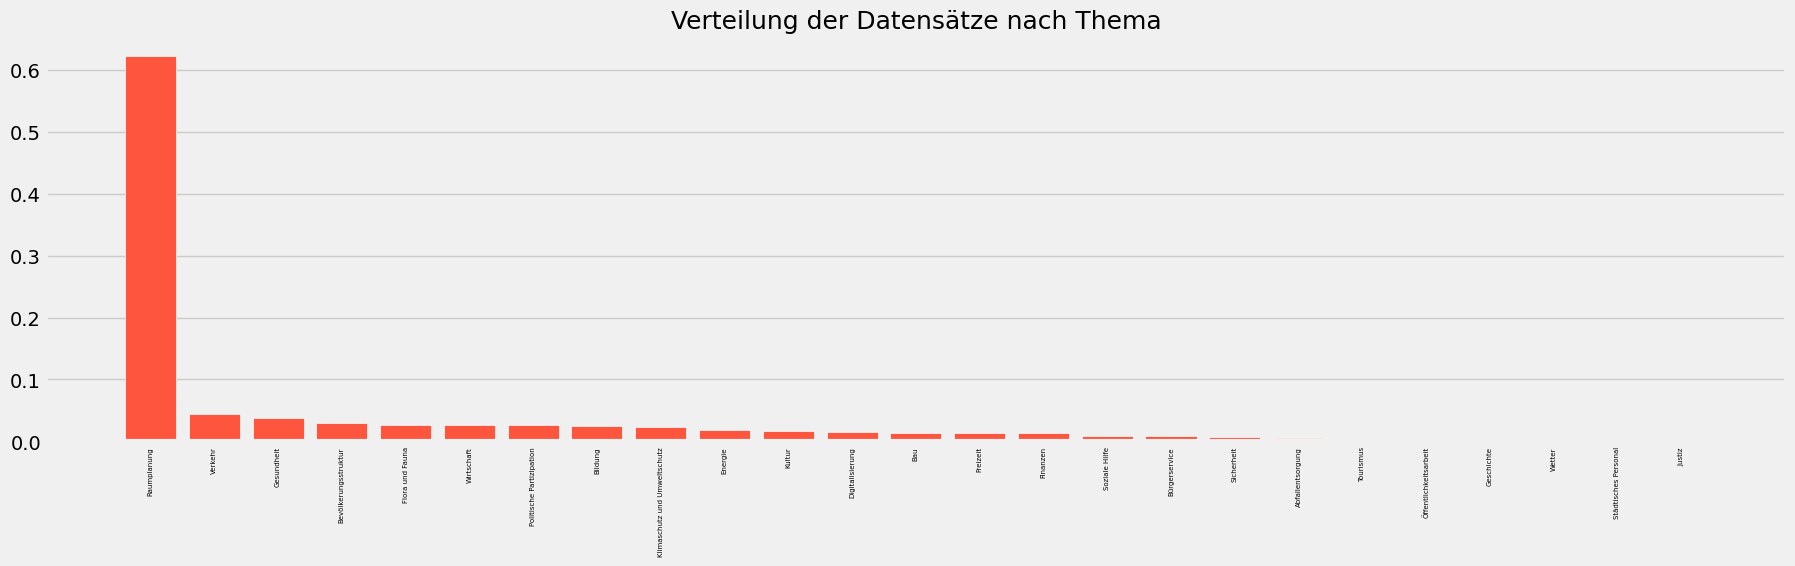

In [46]:
count_thema = count_categories(df=data, column_name='THEMA')
make_distribution_fig(df_count= count_thema, df=data, counter = 'uuid', variable='THEMA', mode='percentage', title="Verteilung der Datensätze nach Thema")

# BEZEICHNUNG

In [24]:
# Exploration data['BEZEICHNUNG']
print(data['BEZEICHNUNG'].value_counts())
print('unique Bezeichnungen:', len(data['BEZEICHNUNG'].unique()))

Bebauungsplan                    5986
Raumgliederung - Stadtgebiet      710
Raumgliederung - Straße           552
Gesundheitsberichterstattung      448
Orthofoto                         342
                                 ... 
Quelle - Personalverzeichnis        2
Haushalt - Sponsoring               1
Feuerwehr - Personal                1
Rettungshilfe - Notfallnummer       1
Wahl - Kandidatenliste              1
Name: BEZEICHNUNG, Length: 241, dtype: int64
unique Bezeichnungen: 241


Excluded catgories: 213


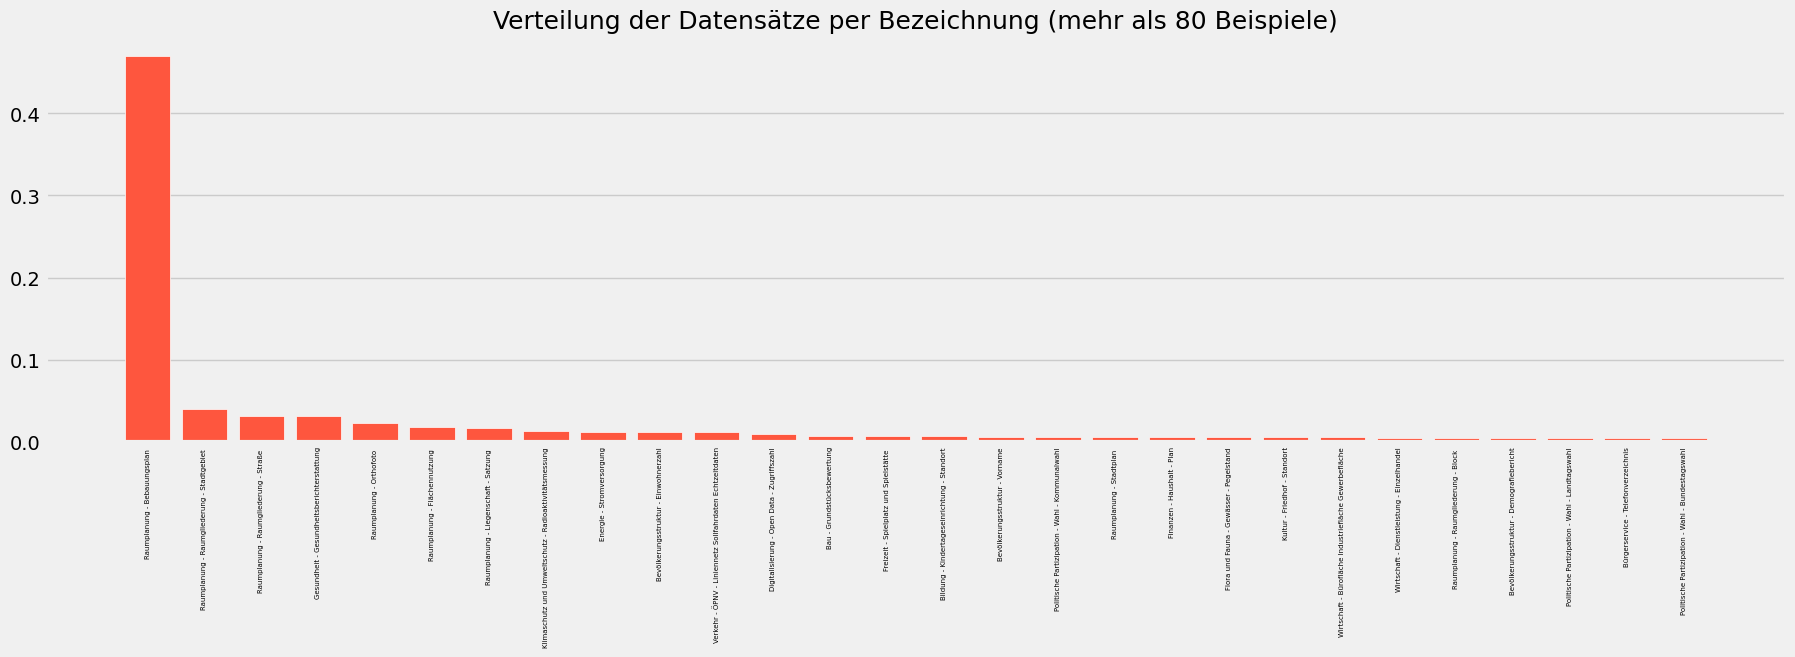

In [47]:
count_bezeichnung = count_categories(df=data, column_name='MUSTERDATENSATZ', limit=80)
make_distribution_fig(df_count= count_bezeichnung, df=data, counter = 'uuid', variable='MUSTERDATENSATZ', mode='percentage', title="Verteilung der Datensätze per Bezeichnung (mehr als 80 Beispiele)")

# MUSTERDATENSATZ

In [48]:
# Exploration data['BEZEICHNUNG']
print(data['MUSTERDATENSATZ'].value_counts())
print('unique Musterdatensatz:', len(data['MUSTERDATENSATZ'].unique()))

Raumplanung - Bebauungsplan                                          9339
Raumplanung - Raumgliederung - Stadtgebiet                            768
Raumplanung - Raumgliederung - Straße                                 619
Gesundheit - Gesundheitsberichterstattung                             611
Raumplanung - Orthofoto                                               452
                                                                     ... 
Bildung - Schule - Schuleingangsuntersuchung                            2
Wirtschaft - Beteiligung an Öffentlicher Wirtschaft - Beteiligung       2
Geschichte - Quelle - Entschädigung                                     2
Finanzen - Haushalt - Sponsoring                                        1
Politische Partizipation - Wahl - Kandidatenliste                       1
Name: MUSTERDATENSATZ, Length: 240, dtype: int64
unique Musterdatensatz: 240


Excluded catgories: 213


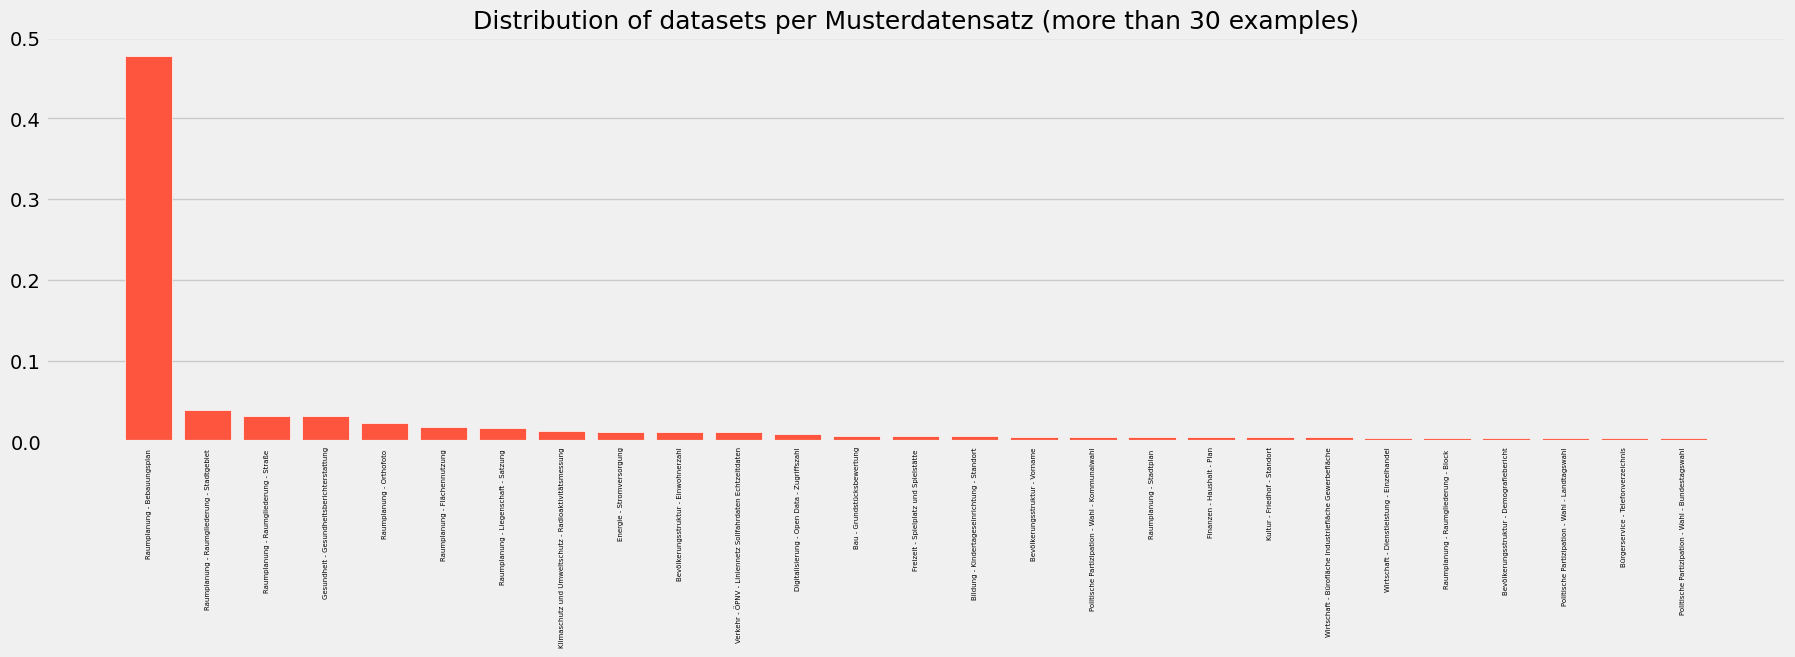

In [50]:
count_musterdatensatz = count_categories(df=data, column_name='MUSTERDATENSATZ', limit=80)
make_distribution_fig(df_count= count_musterdatensatz, df=data, counter = 'uuid', variable='MUSTERDATENSATZ', mode='percentage', title="Distribution of datasets per Musterdatensatz (more than 30 examples)")

# Timeline

2023-04-13 08:42:02,898 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-04-13 08:42:02,903 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


The data was updated 1132 times
We have data ranging from 2013 until 2023


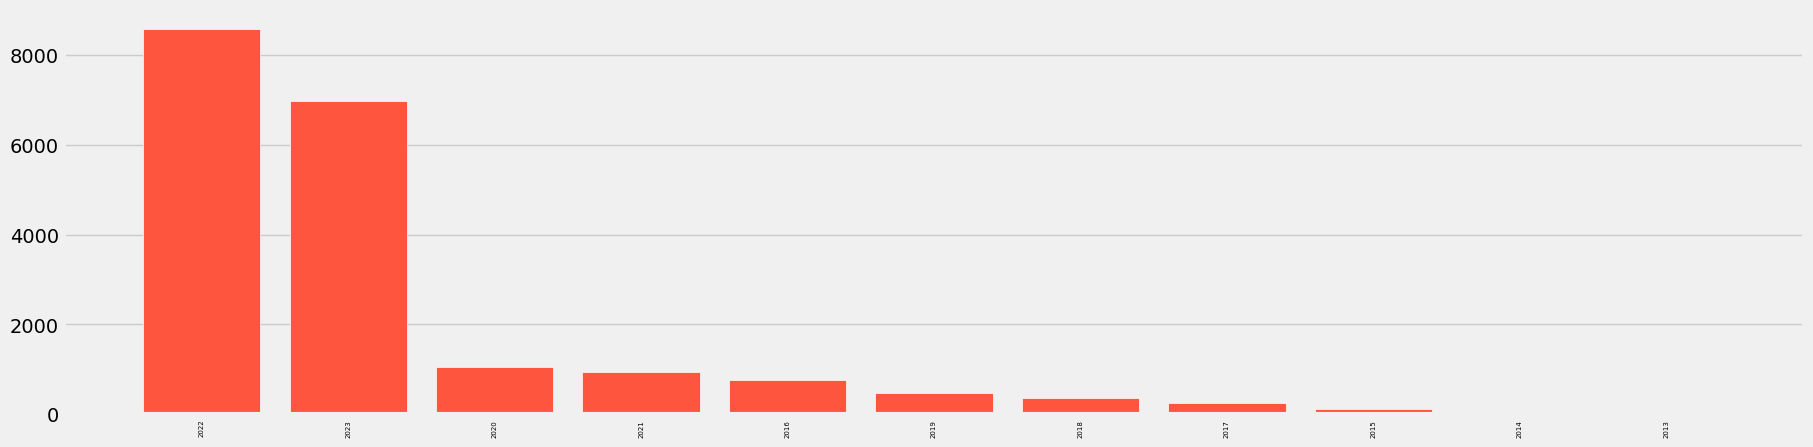

In [51]:
print(f'The data was updated {len(data["updated_at"].unique())} times' )

data['time_processed'] = pd.to_datetime(data['updated_at'],format='%Y-%m-%d')
print(f"We have data ranging from {data['time_processed'].min().year} until {data['time_processed'].max().year}")

data['time_processed'] = data['time_processed'].dt.to_period('Y')

count_time = count_categories(df=data, column_name='time_processed')
count_time['time_processed'] = count_time['time_processed'].astype(str)
make_distribution_fig(df_count= count_time, df=data, counter = 'uuid', variable='time_processed', mode='distribution')


In [55]:
# Exploration of new cities 
print(f"{len(set(enriched_dataset['ORG']).intersection(set(data['ORG'])))} common cities")
print(f"{len(set(enriched_dataset['ORG']).difference(set(data['ORG'])))} missing cities")
print(f"{len(set(data['ORG'].unique()).difference(set(enriched_dataset['ORG'].unique())))} new cities")
missing_cities = list(set(enriched_dataset['ORG']).difference(set(data['ORG'])))
missing_cities_df = enriched_dataset[enriched_dataset['ORG'].isin(missing_cities)]

229 common cities
6 missing cities
118 new cities


In [34]:
dierdorf = missing_cities_df[missing_cities_df["ORG"] == "Dierdorf"]["dct:identifier"].unique()
print(len( missing_cities_df[missing_cities_df["ORG"] == "Dierdorf"]))

candidate_dierdorf_titles = data[data["dct:identifier"].isin(dierdorf)]
len(candidate_dierdorf_titles[candidate_dierdorf_titles["ORG"] == "Verbandsgemeinde Dierdorf"])

52


52

In [35]:
missing_cities_df[missing_cities_df["ORG"] == "Siegen"]

,dct:title,dct:identifier,dcat:landingpage,dct:description,ORG,dcat:Distribution.dct:license,dcat:theme,updated_at,added,MUSTERDATENSATZ,THEMA,BEZEICHNUNG,uuid
1345,Wasserstandsvorhersagen Uni Siegen,519296cb-4b92-4754-af05-dafa41f3b984,https://mcloud.de/web/guest/suche/-/results/de...,Berechnung von Wasserstandsdaten in der Nordse...,Siegen,http://dcat-ap.de/def/licenses/geonutz/20130319,Umwelt,2018-03-01,2022-03-22,Gesundheitseinrichtungen - Krankenhäuser,Gesundheitseinrichtungen,Krankenhäuser,3e38aced-9773-428b-8ba6-2717e497e8af
11039,Wasserstand Datenpunkte,0aca76ce-05b3-4a69-ae0f-7fd591582b37,https://mcloud.de/web/guest/suche/-/results/de...,72 stündige Wasserstandsberechnung auf Basis d...,Siegen,http://dcat-ap.de/def/licenses/geonutz/20130319,Umwelt,2018-03-12,2022-03-22,Gewässer - Pegelstände,Gewässer,Pegelstände,e88f919c-f279-4c21-9b44-5dcdfb6a65cd


In [21]:
missing_cities

['Wesseling',
 'Dierdorf',
 'Waltrop',
 'Menden',
 'Gemeinde Stadt Meiningen',
 'Siegen']

In [66]:
filtered_data_from_pipeline[filtered_data_from_pipeline["file_path"] == "extraction/gov_data_responses/bebauungsplanubersicht-der-stadt-wesseling.xml"]
all_data_from_pipeline[all_data_from_pipeline["file_path"] == "extraction/gov_data_responses/bebauungsplanubersicht-der-stadt-wesseling.xml"]

,dct:title,dct:identifier,url,dct:description,distribution_description,city,license,categories,tags,updated_at,added,file_path,thema,bezeichnung


In [49]:
df_test_pivot = pd.read_excel("data/raw/Musterdatenkatalog-3_1-Deutschland_220424.xlsx")

In [56]:
len(set(enriched_dataset["ORG"]))

235

In [54]:
len(set(data["ORG"]))

347

In [57]:
check_if_same_1 = pd.read_csv("2023-04-20_musterdatenkatalog[91]/2023-04-20_musterdatenkatalog.csv")
check_if_same_2 = pd.read_excel("2023-04-20_musterdatenkatalog[91]/2023-04-20_musterdatenkatalog.xlsx")

True